Implementation of 2D Wavelet transform using Prof Heinecke's preferred wavelets.

In [1]:
from __future__ import division
import numpy as np
import scipy
import skimage
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data, io, filters
from math import sqrt
import itertools
from scipy import signal
import pywt

<b> Part I: 2D-Wavelet Transform</b>

We try to write as generalizable code as possible so it may be adapted easily for other wavelets, for the inverse transform etc.

In [113]:
#use one of these--
#takes an image, pads it, convolves it with a given filter-mask
# def conv_with_mask(inp_image, mask):
    
#     #simple 1d convolution with symmetric padding applied row by row to image
#     conv = [np.convolve(mask, (np.pad(x, len(mask), mode='symmetric')),'full')  for x in inp_image]
    
#     #drop the symmetric padding applied to the image to avert boundary artifacts
#     padding_length = len(conv[0]) - len(inp_image[0])
#     unpadded_conv = np.array([x[int(padding_length/2): int(len(x) -(padding_length/2))] for x in conv])
    
#     return unpadded_conv

##take Abhinav's advice and just apply simple convolution with extension by zeros
def conv_with_mask(inp_image, mask):
    
    #simple 1d convolution with symmetric padding applied row by row to image
    conv = [np.convolve(mask, x, mode='same')  for x in inp_image]
    
    return conv

# def conv_with_mask(inp_image,filter_bank):
#     return signal.convolve2d(inp_image, filter_bank, mode="valid")

In [114]:
linear_masks

[[0.25, 0.5, 0.25],
 [0.3535533905932738, 0, -0.3535533905932738],
 [-0.25, 0.5, -0.25]]

In [115]:
#returns the approximation and corrections for a given image and filter bank
def twodwt_onelevel(inp_image, filter_bank):
    
    #first we address the (h0,h0) type cases. 
    res_arr = [] #this will hold the approx and the corrections
    for fil in filter_bank:
        conv_1 = conv_with_mask(inp_image.T, fil)
        conv_2 = conv_with_mask(np.array(conv_1).T, fil)
        res_arr.append(conv_2)
    
    #find all combinations of filters. e.g. (h0, h1), (h0, h2) etc. 
    #this is without replacement so it will avoid (h0, h0) type cases
    fil_combs = itertools.combinations(filter_bank, 2)
    
    for fil_comb in fil_combs:
        
        conv_1 = conv_with_mask(inp_image.T, fil_comb[0])
        conv_2 = conv_with_mask(np.array(conv_1).T, fil_comb[1])
        res_arr.append(conv_2)
        
        conv_3 = conv_with_mask(inp_image.T, fil_comb[1])
        conv_4 = conv_with_mask(np.array(conv_3).T, fil_comb[0])
        res_arr.append(conv_4)
        
    return np.array(res_arr)

Okay, great! Now we're ready to apply the transform to an image. Let's pick our favorite...

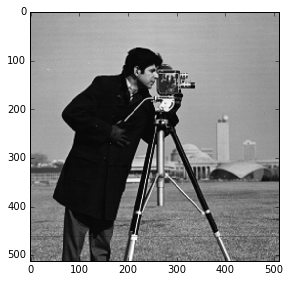

In [116]:
im = data.camera()
io.imshow(data.camera())

In [117]:
#try the piecewise linear wavelet
linear_masks = [[1/4, 1/2, 1/4] , [sqrt(2)/4,0, -sqrt(2)/4], [-1/4, 1/2, -1/4]] #h0, h1, h2

#apply the transform
twodwt_linear_cameraman = twodwt_onelevel(im, linear_masks)

In [118]:
im.shape #the cameraman image is 512x512

(512L, 512L)

In [119]:
np.array(twodwt_linear_cameraman).shape #we got back nine 512x512 images as expected

(9L, 512L, 512L)

Now let's look at the various channels and the approximation...this is what Prof Heinecke was showing in class.

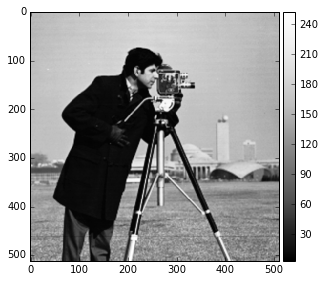

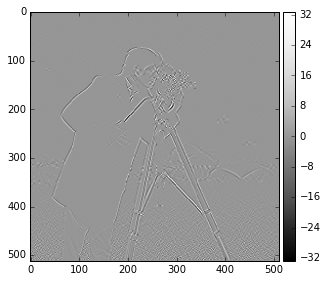

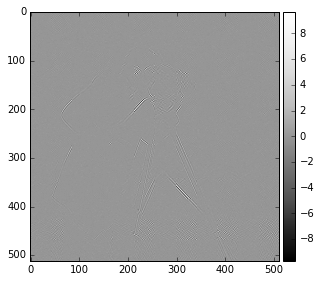

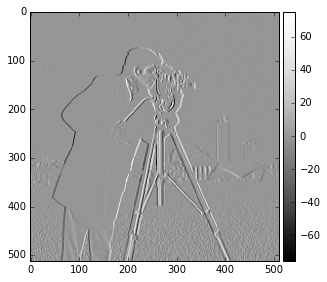

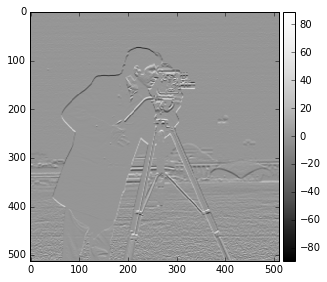

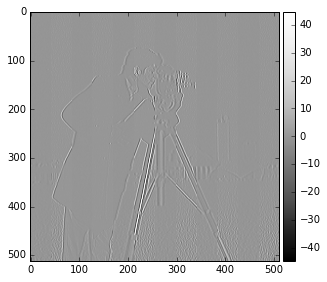

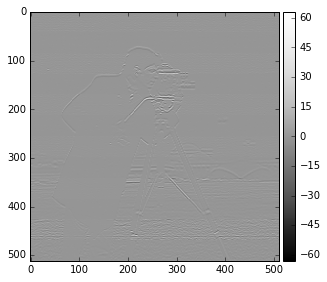

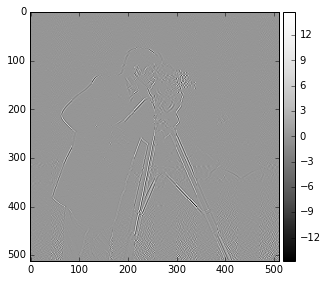

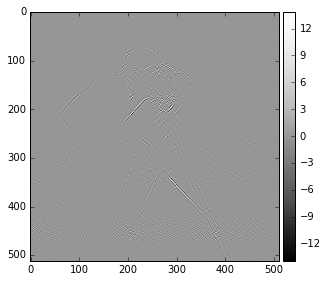

In [120]:
for img in twodwt_linear_cameraman:
    io.imshow(img, cmap = 'Greys_r') #colormap is the "Inverse Greyscale" colormap
    plt.show() #without this, ipython stupidly overlays plot onto plot...

Looks a lot like what Prof showed in class! Our well-generalized functions can be trivially extended to any set of filterbanks/images, so we can do this for the cubic spline wavelets as well...

In [102]:
#try the cubic wavelet
cubic_masks = [[1/16, 1/4, 3/8, 1/4, 1/16], [1/16, -1/4, 3/8, -1/4, 1/16], [-1/8, 1/4, 0, -1/4, 1/8], \
              [sqrt(6)/16, 0, -sqrt(6)/8, 0, sqrt(6)/16], [-1/8, -1/4, 0, 1/4, 1/8] ] #h0, h1, h2, h3, h4

#apply the transform
twodwt_cubic_cameraman = twodwt_onelevel(im, cubic_masks)

In [103]:
np.array(twodwt_cubic_cameraman).shape #as expected we get back 25 images (5x5)

(25L, 512L, 512L)

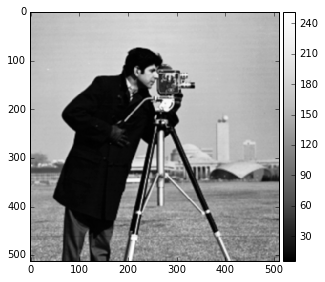

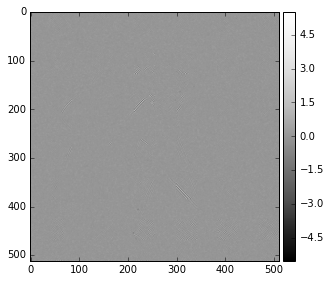

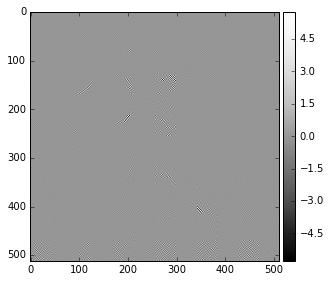

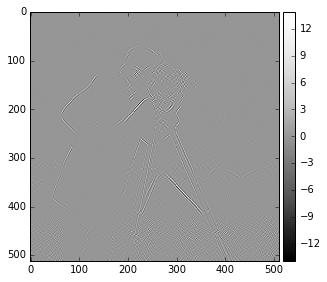

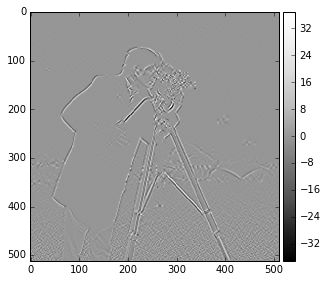

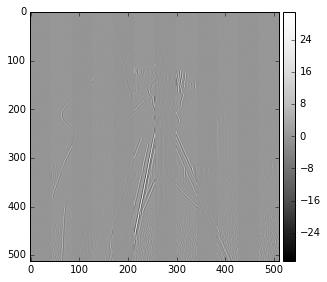

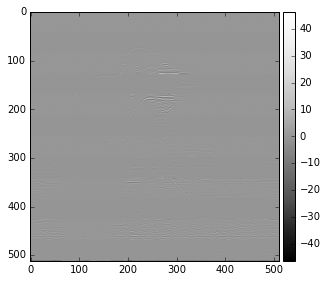

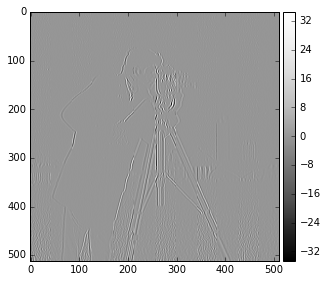

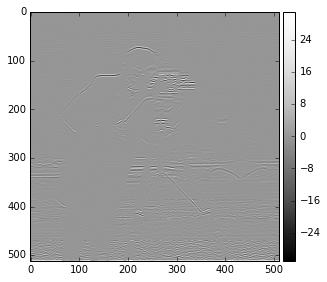

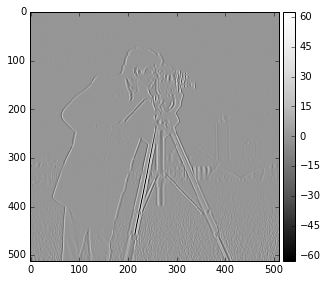

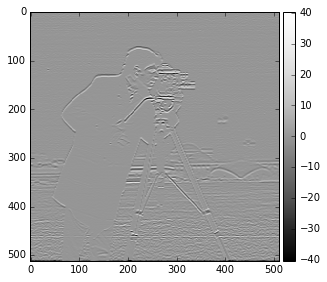

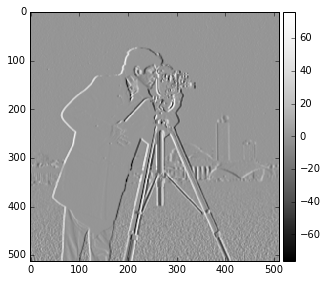

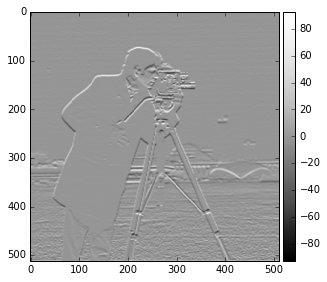

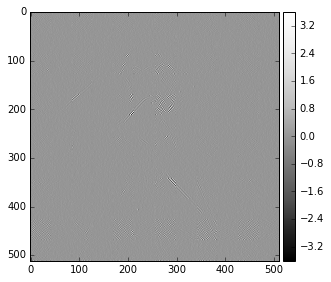

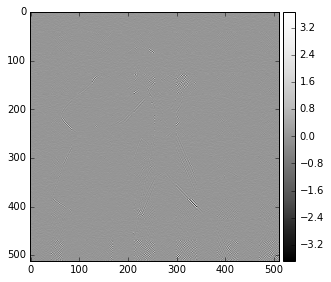

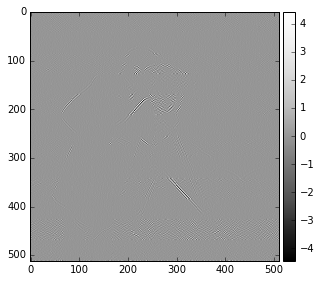

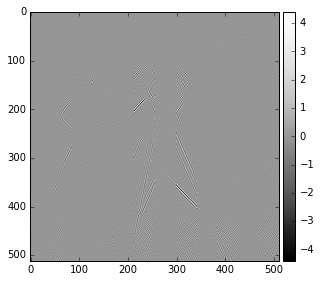

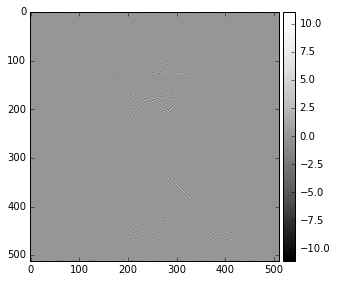

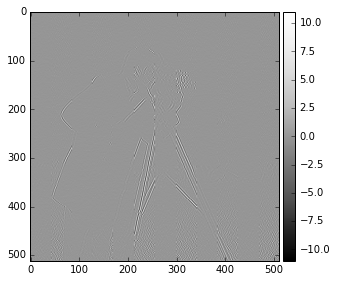

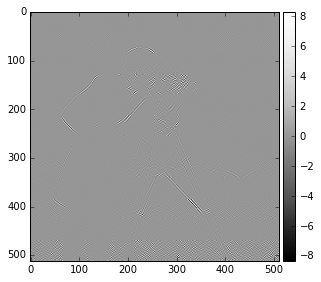

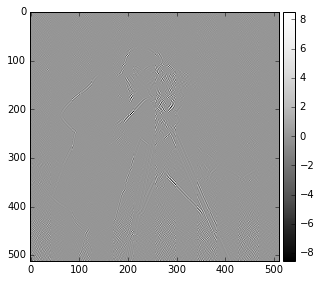

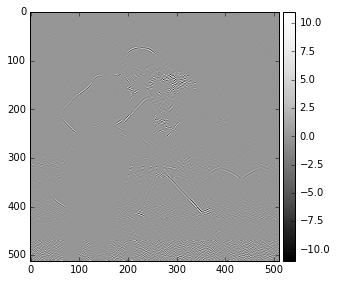

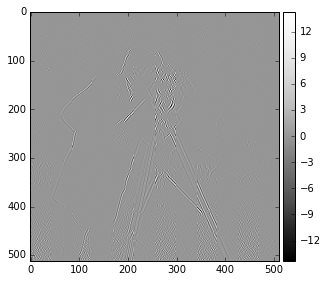

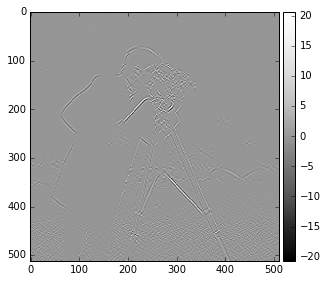

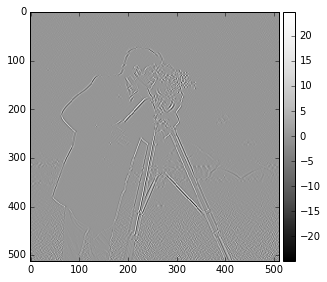

In [104]:
for img in twodwt_cubic_cameraman:
    io.imshow(img, cmap = 'Greys_r') 
    plt.show() 

Very interesting how different channels seem to contain a different "aspect" of the image. Some have the outline of the man and the camera, while some are just so random that one can't make out anything.

With that, we conclude <b>Part I</b>. To summarize: we wrote neat functions that apply the 2D-Wavelet transform given any wavelet filterbank and image. This can be modified (with some thought and effort) to multi-level as well if we are interested.

<b> Part II: Inverse 2D-Wavelet Transform</b>

Okay so now we want to get back the image from the approximation and the coefficients...This can be rather tricky since we must remember the perfect order in which we applied the convolutions. Luckily we used the python-itertools library that standardizes the order of filter-combinations, let's continue working with it!

In [51]:
def inverse_twodwt_onelevel(transformed_image, filter_bank):
    #"transformed_image" here is an array of images containing a) Approximation Image b) Error Images
    inv_filter_bank = [x[::-1] for x in filter_bank] #flip all the filters in the filter-bank
    res_arr = np.zeros(transformed_image[0].shape)  #this will hold the final result
    #count = 0
    
    dfi = len(filter_bank) #double-filter-index = dfi; double-filter=(h0,h0) etc.
    #here we try to reverse the (h0, h0) type cases 
    #we try to invert in LIFO order. Last in, first out. That is, the last convolution we applied in the
    #wavelet transform is the first one to be "undone".
    for inv_fil, trans_img in zip(inv_filter_bank, transformed_image[0:dfi]):
        inv_conv_1 = conv_with_mask(trans_img, inv_fil)
        inv_conv_2 = conv_with_mask(np.array(inv_conv_1).T, inv_fil)
        res_arr = res_arr + np.array(inv_conv_2).T
        #count = count+1
    
    #next we undo the other (h0,h1) type cases in the same order that they were created in
    inv_fil_combs = itertools.combinations(inv_filter_bank, 2)
    trans_img_arr = transformed_image[dfi::]
    
    for inv_fil_comb, trans_img_indx in zip(inv_fil_combs, np.arange(len(trans_img_arr)-1)):
        trans_img = trans_img_arr[trans_img_indx]
        inv_conv_1 = conv_with_mask(trans_img, inv_fil_comb[1])
        inv_conv_2 = conv_with_mask(np.array(inv_conv_1).T, inv_fil_comb[0])
        res_arr = res_arr + np.array(inv_conv_2).T
        #count = count+1
        
        trans_img = trans_img_arr[trans_img_indx+1]
        inv_conv_3 = conv_with_mask(trans_img, inv_fil_comb[0])
        inv_conv_4 = conv_with_mask(np.array(inv_conv_3).T, inv_fil_comb[1])
        res_arr = res_arr + np.array(inv_conv_4).T
        #count=count+1
        
    #print count
    return res_arr

In [98]:
reconstruction = inverse_twodwt_onelevel(twodwt_linear_cameraman, linear_masks)

9


In [52]:
reconstruction = inverse_twodwt_onelevel(twodwt_cubic_cameraman, cubic_masks)

25


Alas! We have failed! The residual image below should have been blank...Let's figure this out with Prof+Abhinav+Brian in class!

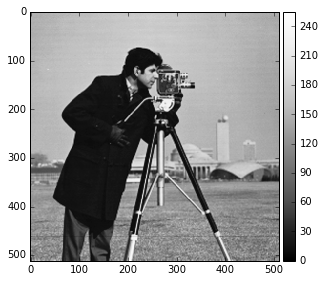

In [99]:
io.imshow( normalize_image(reconstruction, im), cmap = 'Greys_r') 

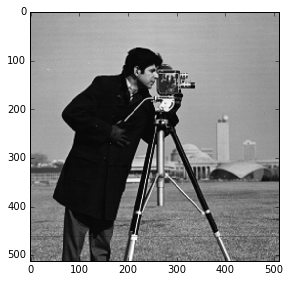

In [100]:
io.imshow(im)

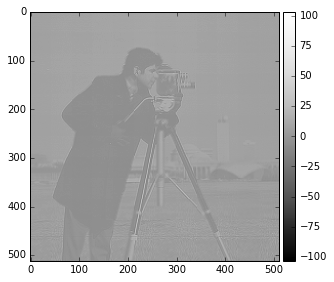

In [101]:
io.imshow(im- normalize_image(reconstruction, im), cmap = 'Greys_r') 

(array([  3.61600000e+03,   4.57230000e+04,   5.47600000e+03,
          4.64500000e+03,   4.16800000e+03,   3.58100000e+03,
          3.80300000e+03,   8.50300000e+03,   1.62400000e+04,
          2.26710000e+04,   2.18060000e+04,   3.49490000e+04,
          5.11860000e+04,   3.04650000e+04,   2.90200000e+03,
          8.83000000e+02,   6.31000000e+02,   6.75000000e+02,
          2.18000000e+02,   3.00000000e+00]),
 array([  -6.02071722,    7.89155634,   21.8038299 ,   35.71610346,
          49.62837702,   63.54065058,   77.45292414,   91.3651977 ,
         105.27747125,  119.18974481,  133.10201837,  147.01429193,
         160.92656549,  174.83883905,  188.75111261,  202.66338616,
         216.57565972,  230.48793328,  244.40020684,  258.3124804 ,
         272.22475396]),
 <a list of 20 Patch objects>)

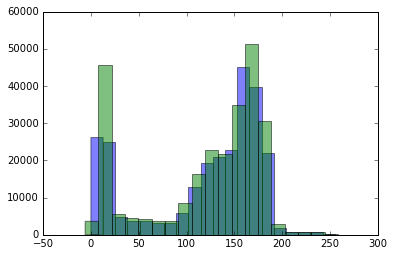

In [69]:
plt.hist(np.ravel(im),20,alpha=0.5)
plt.hist(np.ravel(reconstruction), 20, alpha=0.5)

In [49]:
(np.sum((im-reconstruction)**2))**(0.5)

2546.1789874035085

In [42]:
#convert ranges in a logical manner

def normalize_image(old_image, new_image):
    #NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    
    NewValue = (((old_image - np.min(old_image)) * (np.max(new_image) - np.min(new_image)))/(np.max(old_image) - np.min(old_image)))\
    + np.min(new_image)
    
    return NewValue